# Analysis of Money Supply in the Eurozone
Money supply in the Eurozone is not much different from that in the US and is made up of the following money aggregates:

Type of money | MB | M1 | M2 | M3
--- | --- | --- | --- | ---
Currency in circulation | ✓ | ✓ | ✓ | ✓
Reserve balances | ✓ |  |   |  
Overnight deposits (aka Demand deposits) |  | ✓ | ✓ | ✓ 
Deposits with an agreed maturity of up to 2 years or redeemable at notice of up to 3 months |  |  | ✓ | ✓
Repurchase agreements, Money market funds, Debt securities with maturity of up to 2 years |  |  |  | ✓

As you can see from the above table, `MB` currency in circulation < `M1` < `M2` < `M3` as each of the larger money supply aggregates includes the preceeding one. I use both nominal and real measures by adjusting for Eurozone's Harmonized Index of Consumer Prices (HICP).

The only free online source of data for Eurozone's monetary aggregates I was able to find is the OECD. Unfortunately its SDMX API only provides data on M1 and M3 aggregates. Analogously with [the Money supply analysis for the US](./Money_Supply.ipynb) I use not seasonally adjusted datasets.

In [1]:
# Uncomment if running in Google Colaboratory

# Install the latest version of pandaSDMX
# !pip install pandaSDMX -U
# !pip install eurostat -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthBegin, BDay, QuarterBegin

import eurostat
import pandasdmx as sdmx

from datetime import date
import re

from dateutil.relativedelta import relativedelta

/usr/local/lib/python3.9/site-packages/pandasdmx/remote.py:11: RuntimeWarning: optional dependency requests_cache is not installed; cache options to Session() have no effect
  warn(


In [3]:
report_start = date.fromisoformat('2008-10-01')
report_end = date.today()

### Preparing factors for conversion from nominal to real amounts by adjusing for monthly Harmonized Index of Consumer Prices (HICP &mdash; Eurozone's CPI)

In [4]:
# Using Eurozone price index 2015=100, and All-items HICP: CP00 
eu_hicp = eurostat.get_data_df('prc_hicp_midx',
               filter_pars={'startPeriod': report_start, 'unit': 'I15', 'coicop': 'CP00', 'geo': 'EA'}).iloc[:, 3:]
eu_hicp = eu_hicp.set_index(eu_hicp.columns[0]).T
eu_hicp = eu_hicp.set_axis(pd.DatetimeIndex(eu_hicp.index, 'MS'))

## Analysis of annual changes in the main components of M3

In [5]:
oecd = sdmx.Request('OECD')
data_msg = oecd.data('MEI', key='EA19+EA20.MANMM101+MABMM301.ST+STSA.M', params={'startPeriod': report_start, 
                                                                                 'endPeriod': report_end})

In [6]:
m1_total = sdmx.to_pandas(data_msg.data[0]).loc['EA19', 'MANMM101', 'STSA', 'M'].rename('M1')
m1_total = m1_total.set_axis(pd.DatetimeIndex(m1_total.index, 'MS'))
m3_total = sdmx.to_pandas(data_msg.data[0]).loc['EA19', 'MABMM301', 'STSA', 'M'].rename('M3 Total')
m3_total = m3_total.set_axis(pd.DatetimeIndex(m3_total.index, 'MS'))

In [7]:
m3_components = (m3_total-m1_total).rename('M2 and M3 Add-ons')

In [8]:
m3_df = pd.concat([m3_total, m1_total, m3_components], axis=1)

In [9]:
m3_df

,M3 Total,M1,M2 and M3 Add-ons
TIME_PERIOD,,,
2008-10-01,9326.351,3944.467,5381.884
2008-11-01,9367.448,3969.681,5397.767
2008-12-01,9423.780,4035.742,5388.038
2009-01-01,9400.007,4096.150,5303.857
2009-02-01,9414.395,4101.868,5312.527
...,...,...,...
2023-04-01,16026.226,10896.903,5129.323
2023-05-01,16006.484,10810.018,5196.466
2023-06-01,16010.609,10744.243,5266.366


In [10]:
last_idx = min(eu_hicp.index[-1], m3_df.index[-1])
eu_hicp = eu_hicp.loc[:last_idx]
# Convert into pandas.Series
nom_2_real_conv_factors = (eu_hicp.iloc[-1] / eu_hicp).iloc[:,0].rename('Conversion factor')

# Convert from nominal into real money supply
m3real_df = m3_df.multiply(nom_2_real_conv_factors, axis=0).dropna()

m3real_df.rename(
    columns={m3_df.columns[0]: 'Real ' + m3_df.columns[0], m3_df.columns[1]: 'Real ' + m3_df.columns[1],
             m3_df.columns[2]: 'Real ' + m3_df.columns[2]},
    inplace=True)

In [11]:
m3real_df

,Real M3 Total,Real M1,Real M2 and M3 Add-ons
TIME_PERIOD,,,
2008-10-01,12567.876081,5315.430704,7252.445377
2008-11-01,12685.277601,5375.690953,7309.586647
2008-12-01,12778.303634,5472.319670,7305.983963
2009-01-01,12852.859312,5600.766007,7252.093305
2009-02-01,12820.239480,5585.800264,7234.439216
...,...,...,...
2023-04-01,16144.678450,10977.443787,5167.234663
2023-05-01,16120.862448,10887.263764,5233.598684
2023-06-01,16083.225352,10792.973672,5290.251680


## Visualization of Eurozone's Nominal M3 Money Supply

In [12]:
M3_COMPOSITION_TITLE = 'Composition of Eurozone M3 Money Supply'
REALM3_COMPOSITION_TITLE = 'Composition of Eurozone Real M3 Money Supply'
IN_EURO_FORMATER = ' in {:%Y-%m} Euros'
LEFT_Y_AXIS_LABEL = 'Billions of Euros'

### Stacked Visualization Amounting to Total Eurozone M3 Money Supply

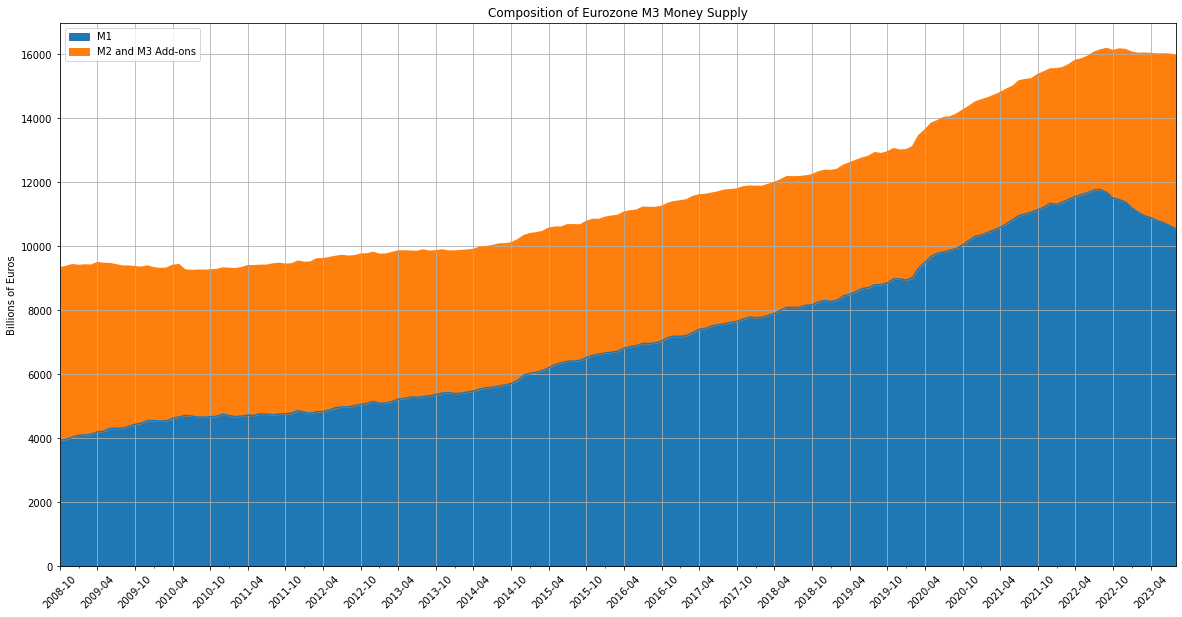

In [13]:
ax = m3_df.iloc[:,1:].plot.area(figsize=(20,10), grid=True, title=M3_COMPOSITION_TITLE,
                     xticks=m3_df.index[::6], xlabel='', rot=45,
                     ylabel=LEFT_Y_AXIS_LABEL)#, yticks=np.arange(0, 25e3, 2.5e3))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_df.index[::6])))

In [14]:
idxmax = m3_total.idxmax()
print('Nominal M3 money supply maximum of \u20ac{:>8.2f}bn reached in month {:%Y-%m}'
      .format(m3_total.loc[idxmax], idxmax))
print('Nominal M3 money supply shrank by  \u20ac{:>8.2f}bn since (as of month {:%Y-%m})'
      .format(m3_total.iloc[-1]-m3_total.loc[idxmax], m3_total.index[-1]))
print('Nominal M2 money supply shrank by  \u20ac{:>8.2f}bn since {:%Y-%m} to \u20ac{:.2f}bn'
      .format(m3_total.iloc[-1]-m3_total.iloc[-2], m3_total.index[-2], m3_total.iloc[-1]))

Nominal M3 money supply maximum of €16179.60bn reached in month 2022-09
Nominal M3 money supply shrank by  € -214.85bn since (as of month 2023-08)
Nominal M2 money supply shrank by  €  -39.50bn since 2023-07 to €15964.75bn


In [15]:
m3_df.iloc[-1,:] - m3_df.iloc[-2,:]

M3 Total             -39.496
M1                  -100.030
M2 and M3 Add-ons     60.534
dtype: float64

### Visualization as Percent of Total Eurozone M3 Money Supply

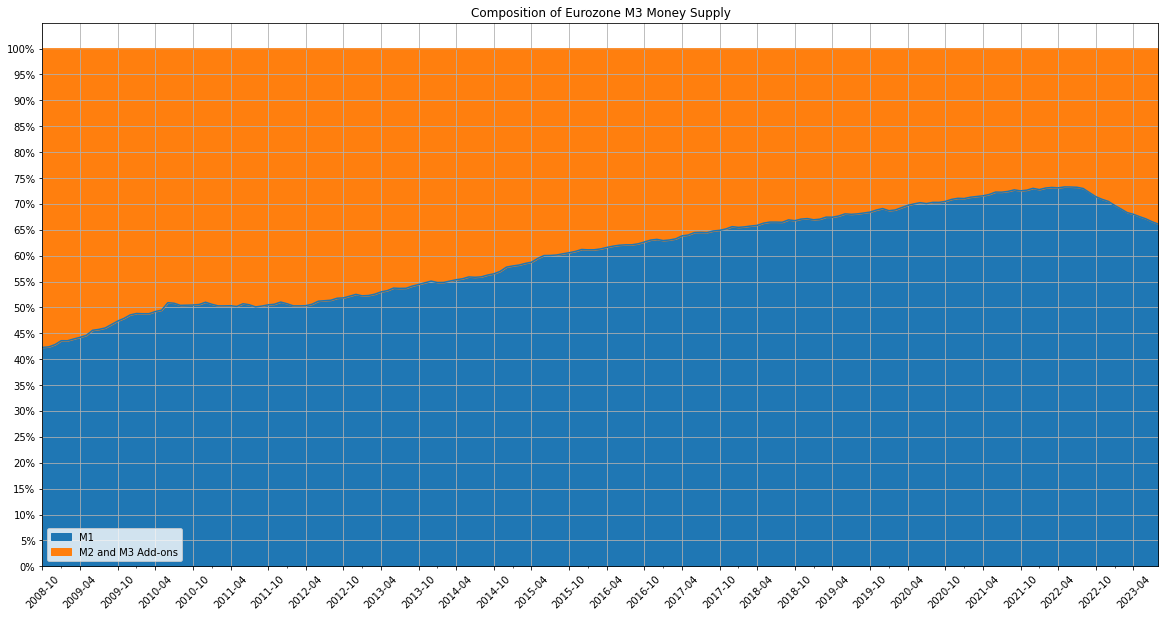

In [16]:
# Converting to percentages by dividing by total M3 Money Supply.
# Dividing by the total M3 Money Supply
m3_df_pct = m3_df.iloc[:,1:].divide(m3_total, axis=0)
m3_df_pct *= 100

ax = m3_df_pct.plot.area(figsize=(20,10), grid=True, title=M3_COMPOSITION_TITLE,
                              xticks=m3_df_pct.index[::6], xlabel='', rot=45,
                              yticks=np.arange(0, 101, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_df_pct.index[::6])))

In [17]:
m3_df_pct.iloc[-1,:] - m3_df_pct.iloc[-2,:]

M1                  -0.461931
M2 and M3 Add-ons    0.461931
dtype: float64

## Visualization of Eurozone's Real M3 Money Supply

### Stacked Visualization Amounting to Total Eurozone Real M3 Money Supply

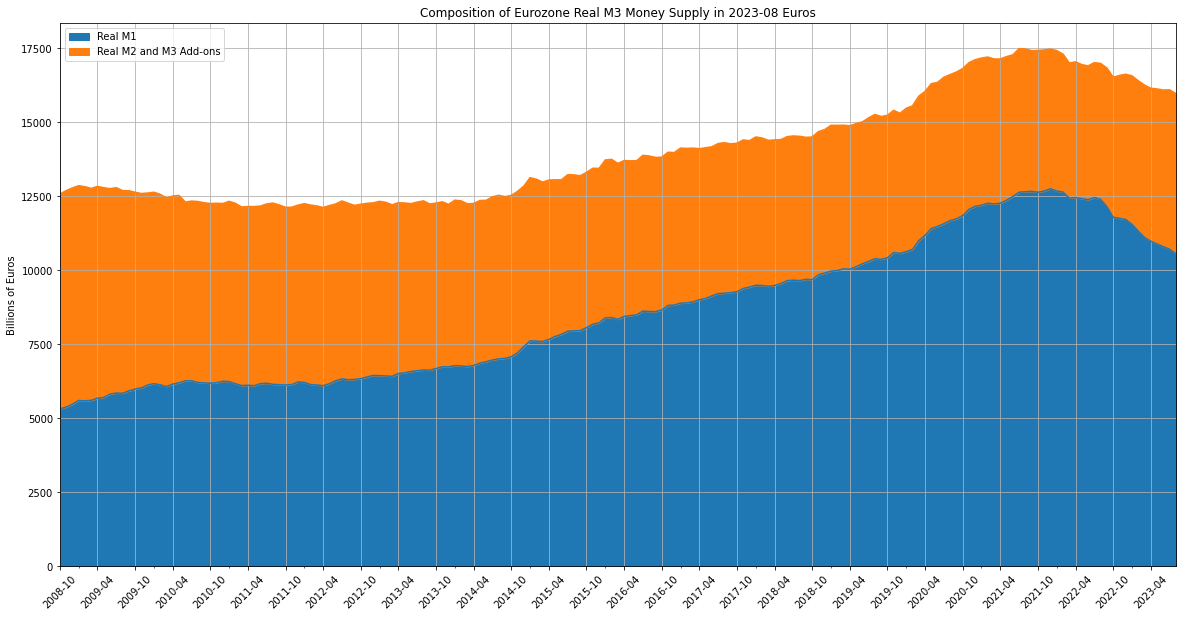

In [18]:
ax = m3real_df.iloc[:,1:].plot.area(
                figsize=(20,10), grid=True,
                title=REALM3_COMPOSITION_TITLE + IN_EURO_FORMATER.format(m3real_df.index[-1].date()),
                xticks=m3real_df.index[::6], xlabel='', rot=45,
                ylabel=LEFT_Y_AXIS_LABEL)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3real_df.index[::6])))

In [19]:
idxmax = m3real_df.iloc[:,0].idxmax()
print('Real M3 money supply maximum of \u20ac{:>8.2f}bn reached in month {:%Y-%m}'
      .format(m3real_df.loc[idxmax,m3real_df.columns[0]], idxmax))
print('Real M3 money supply shrank by  \u20ac{:>8.2f}bn since (as of month {:%Y-%m})'
      .format(m3real_df.iloc[-1,0]-m3real_df.loc[idxmax,m3real_df.columns[0]], m3real_df.index[-1]))
print('Real M3 money supply shrank by  \u20ac{:>8.2f}bn since {:%Y-%m} to \u20ac{:.2f}bn'
      .format(m3real_df.iloc[-1,0]-m3real_df.iloc[-2,0], m3real_df.index[-2], m3real_df.iloc[-1,0]))

Real M3 money supply maximum of €17483.93bn reached in month 2021-07
Real M3 money supply shrank by  €-1519.17bn since (as of month 2023-08)
Real M3 money supply shrank by  € -126.42bn since 2023-07 to €15964.75bn


In [20]:
m3real_df.iloc[-1,:] - m3real_df.iloc[-2,:]

Real M3 Total            -126.419202
Real M1                  -157.875625
Real M2 and M3 Add-ons     31.456424
dtype: float64

### Visualization as Percent of Total Eurozone Real M3 Money Supply

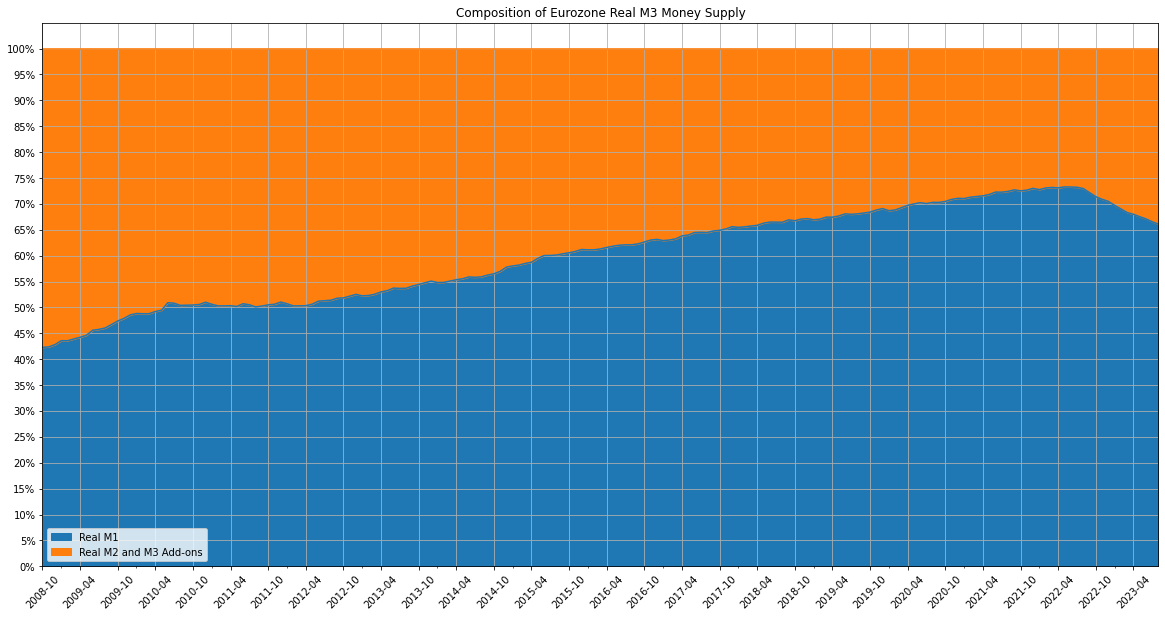

In [21]:
# Converting to percentages by dividing by total M3 Money Supply.
# Dividing by the total M3 Money Supply
m3real_df_pct = m3real_df.iloc[:,1:].divide(m3real_df.iloc[:,0], axis=0)
m3real_df_pct *= 100

ax = m3real_df_pct.plot.area(figsize=(20,10), grid=True, title=REALM3_COMPOSITION_TITLE,
                              xticks=m3real_df_pct.index[::6], xlabel='', rot=45,
                              yticks=np.arange(0, 101, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3real_df_pct.index[::6])))

## Visualizing Annual Percentage Changes in the Main Components of Eurozone's M3 Money Supply

In [22]:
m3_df_speed = (m3_df - m3_df.shift(1)).dropna()

In [23]:
# Converting to annual percentage changes (changes from the corresponding month a year ago)
m3_annual_rate = m3_df.pct_change(12).dropna()

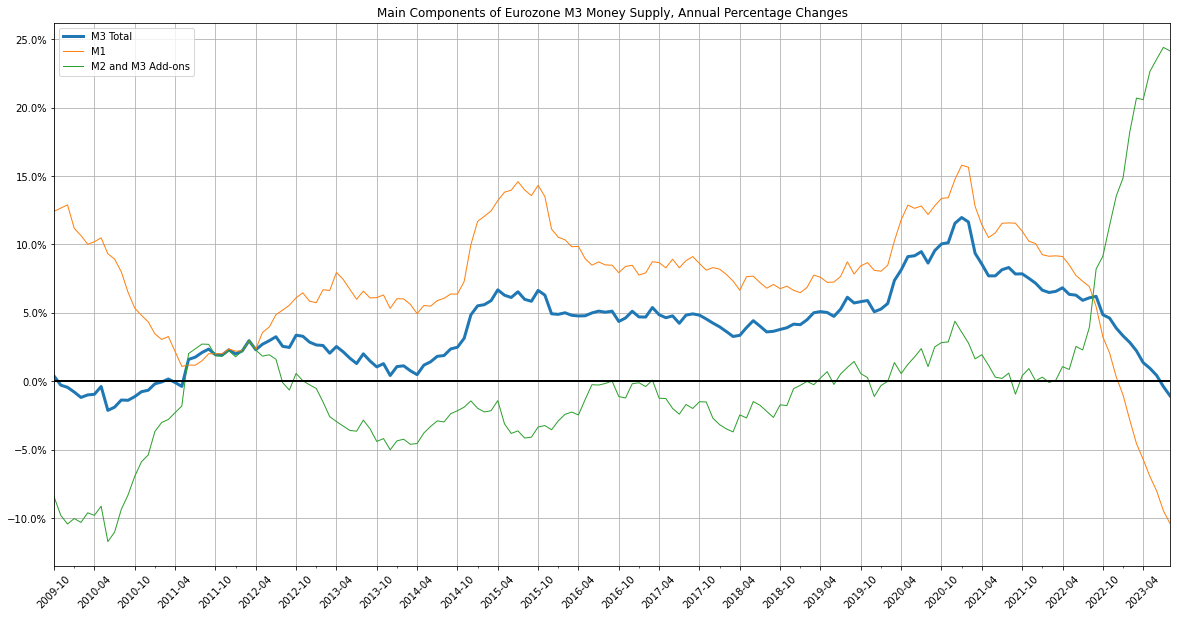

In [24]:
ax = m3_annual_rate.iloc[:,:1].plot(figsize=(20,10), grid=True, linewidth=3,
                        title='Main Components of Eurozone M3 Money Supply, Annual Percentage Changes',
                        xticks=m3_annual_rate.index[::6], xlabel='', rot=45) #, ylim=(-.3,.51),yticks=np.arange(-.30, 0.51, .05),
m3_annual_rate.iloc[:,1:].plot(ax=ax, grid=True, xticks=m3_annual_rate.index[::6], xlabel='', rot=45, linewidth=1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_annual_rate.index[::6])))

In [25]:
pd.options.display.float_format = (lambda x: '{:.3%}'.format(x) if x < 100 else '{:,.0f}bn'.format(x))
m3_annual_rate.tail(12)

,M3 Total,M1,M2 and M3 Add-ons
TIME_PERIOD,,,
2022-09-01,6.209%,5.459%,8.207%
2022-10-01,4.865%,3.246%,9.137%
2022-11-01,4.621%,2.075%,11.385%
2022-12-01,3.883%,0.308%,13.550%
2023-01-01,3.324%,-0.990%,14.849%
2023-02-01,2.844%,-2.819%,18.209%
2023-03-01,2.225%,-4.547%,20.698%
2023-04-01,1.366%,-5.708%,20.586%
2023-05-01,0.953%,-6.957%,22.640%


In [26]:
M3_COMPONENTS_SPEED = 'Speed of changes in Eurozone M3 Money Supply in Billions of Euros per month'
M3REAL_COMPONENTS_SPEED = 'Speed of changes in Eurozone Real M3 Money Supply in Billions of Euros per month'
LEFT_Y_AXIS_LABEL_SPEED = 'Billions of Euros per Month'

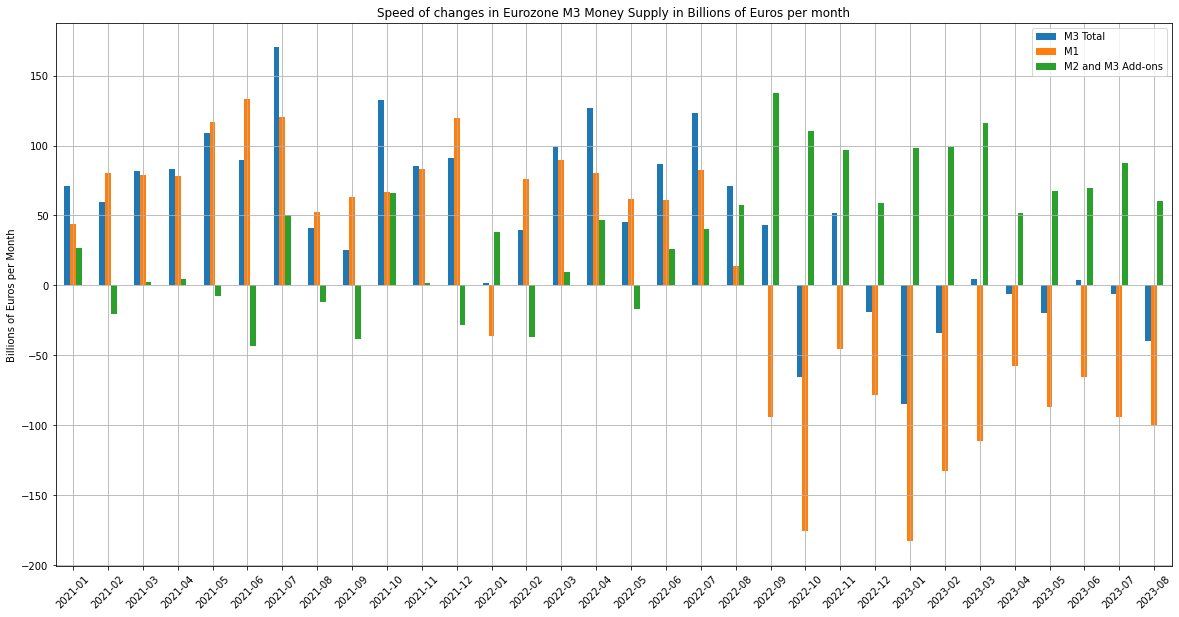

In [27]:
ax = m3_df_speed.loc['2021':].plot.bar(figsize=(20,10), grid=True,
                            title=M3_COMPONENTS_SPEED, 
                            xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL_SPEED)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_df_speed.loc['2021':].index)))